## Seq2seq models and attention

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
EASY_MODE = False        # If True, only translates phrases shorter than 20 characters (way easier).
                         # Useful for initial coding.
                         # If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                # way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  # maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          # how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word, trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

size =  181801


In [3]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [4]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(all_words,test_size=0.1, random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0 192 104 179  92  34  33  81   1   1   1   1   1   1]
 [  0 192  74  10  34  33  81  31  98  29 192 162  34   1]
 [  0 192  29  21 109  74   1   1   1   1   1   1   1   1]
 [  0 192  29  21 143 163   1   1   1   1   1   1   1   1]
 [  0 192  92  34  29 162   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

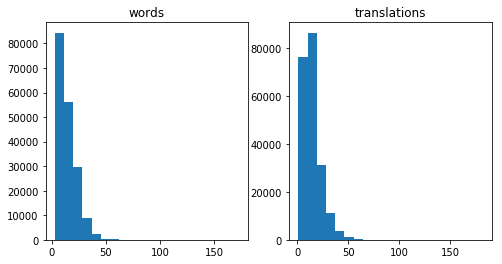

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)), bins=20);


### Step 2: deploy encoder-decoder (2 points)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.weights`__ - weights from all model layers [a list of variables]

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [8]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
from basic_model import BasicTranslationModel
model = BasicTranslationModel('model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

# PLEASE DON'T CHANGE THESE VALUES: emb_size=32, hid_size=64

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [10]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n", out, logp)
print("\nSample translations:\n", s.run(sampled_out))


Symbolic_translate output:
 Tensor("PlaceholderWithDefault_1:0", shape=(?, ?), dtype=int32) Tensor("Reshape_1:0", shape=(?, ?, 325), dtype=float32)

Sample translations:
 [[  0   3 116 253 163  65 211  71 156 319  98]
 [  0  34 210 103 231 319 320 248  54  47 111]
 [  0 144 164  51 322  62 141  29 120 324 183]]


In [11]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp, out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])


Symbolic_score output:
 Tensor("Reshape_3:0", shape=(?, ?, 325), dtype=float32)

Log-probabilities (clipped):
 [[[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.79170847  -5.77294493  -5.78146505  -5.7753191   -5.77644682]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.76692295  -5.79747391  -5.76922894  -5.79463148  -5.7881465 ]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.80375242  -5.76854753  -5.77007532  -5.7679925   -5.78549385]]]


In [12]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)

In [13]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ['ɱرřкր′ḳηפاðחôගタע*:mū仙əīت15čζ', 'πŭñপ老رע野…ףőìmفåłνðőàחťl8(ú猫כ', 'ạタñ→']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [14]:
import editdistance  # !pip install editdistance


def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=100):
    """
    A function that computes levenshtein distance for bsize random samples
    """
    assert isinstance(words, np.ndarray)
    
    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance, batch_words, batch_trans))
    
    return np.array(distances, dtype='float32')

In [15]:
# should be around 5-50 and decrease rapidly after training :)
[score(test_words, 10).mean() for _ in range(5)]

[50.5, 27.700001, 49.900002, 39.700001, 56.0]

**Note:** these numbers I got with EASY_MODE = False. With EASY_MODE = True it was around 30, so everything should be okey :)

## Step 3: Training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [16]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32', [None, None])
    reference_answers = tf.placeholder('int32', [None, None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = -select_values_over_last_axis(logprobs_seq, reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask) / tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    train_step = tf.train.AdamOptimizer().minimize(loss, var_list=model.weights)
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [17]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x, batch_y = sample_batch(train_words, word_to_translations, 10)
    """
    #choose words
    batch_words = np.random.choice(words, size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [18]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[  0  98 179  34  74 111   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1]
 [  0 169 179  34 104  21 179 169   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1]
 [  0  98  10 169  74 179  34 163 184 140 179  74 101  74 140  31  29 179
  101  74 192 140  31  85  34 104  34  34  81   1]]
Target:
[[  0  45  20  91  27 174 174 159 211   1   1   1   1   1   1   1   1   1
    1   1   1]
 [  0 100  91  77 211 309  39  91 100   1   1   1   1   1   1   1   1   1
    1   1   1]
 [  0 159  83 256 176 256  20 174  72 159 174 159 100  77  53  78  91 146
  100  32   1]]


In [19]:
from IPython.display import clear_output
from tqdm import tqdm, trange

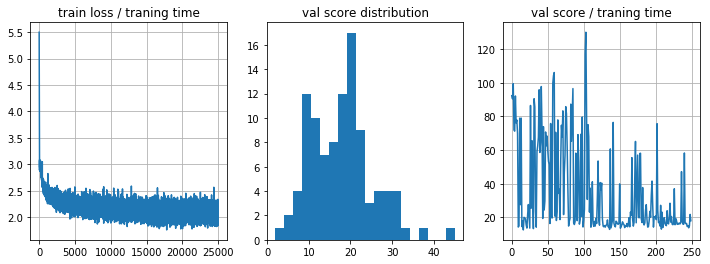

100%|██████████| 25000/25000 [14:56<00:00, 27.89it/s]

llh=2.075, mean score=20.573


In [21]:
loss_history=[]
editdist_history = []

for i in trange(25000):
    bx,by = sample_batch(train_words, word_to_translation, 32)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss, _ = s.run([supervised_training.loss,supervised_training.train_step], feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [22]:
for word in train_words[:10]:
    print("%s -> %s"%(word, translate([word])[0]))

שריר הטרפז -> serial states
סוורן סוזוקי -> states
ח'ארג -> the states
מוזיקה מנוונת -> art in the united states
אריסימון -> art in the united st
java -> south states
לטימריה -> art in the united 
אנווטאק -> art in the united 
ג'יימי לי קרטיס -> south states
קטגוריה:ילדי נשיאי ארצות הברית -> south states


In [23]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))

100%|██████████| 569/569 [00:09<00:00, 58.58it/s]

Supervised test score: 17.0568175568


## Step 4: Make it actually work (up to 26 points)

In this section we want you to experiment to find a good model for the task.

**What would be good**:

1) try different recurrent units

2) implement attention - compulsory!

3) try bidirectional rnn/gru/lstm

4) try different functions for attention

5) any other ideas are welcome!

**Requirements**:

1) less than 1.2 llh

2) less than 6 points test score

3) don't change emb_size=32, hid_size=64 (if you're using bidirectional rnn, hid size for each must be 32 to get overall hid_size=64)

**What we expect to get**:

1) results with models in this notebook (top-n models)

2) a brief report describing your experiments and results: what have you tried, why, etc.

**What files you need to send**:

1) this notebook

2) file .py similar to ours basic_model.py with all your models and attentions


Below is the version of attention template: you can use it if you want.

Some functions to launch training easier

In [22]:
def evaluate(words, supervised_training, bsize=100):
    batch_words = np.random.choice(words, size=bsize, replace=False)
    lines_ix = inp_voc.to_matrix(batch_words)

    # Compute translations in form of indices
    trans_ix = s.run(supervised_training.greedy_translations,
                     {supervised_training.input_sequence: lines_ix})

    # Convert translations back into strings
    batch_trans = out_voc.to_lines(trans_ix)
    
    distances = list(map(get_distance, batch_words, batch_trans))
    
    return np.array(distances, dtype='float32')

In [23]:
def train(model):
    class supervised_training:
        # variable for inputs and correct answers
        input_sequence = tf.placeholder('int32', [None, None])
        reference_answers = tf.placeholder('int32', [None, None])
        
        greedy_translations, _ = model.symbolic_translate(input_sequence, greedy=True)
        
        # Compute log-probabilities of all possible tokens at each step. Use model interface.
        logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

        # compute mean crossentropy
        crossentropy = - select_values_over_last_axis(logprobs_seq, reference_answers)

        mask = infer_mask(reference_answers, out_voc.eos_ix)

        loss = tf.reduce_sum(crossentropy * mask) / tf.reduce_sum(mask)

        # Build weights optimizer. Use model.weights to get all trainable params.
        train_step = tf.train.AdamOptimizer(1e-3).minimize(loss, var_list=model.weights)
    
    def translate(lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(supervised_training.greedy_translations,
                         {supervised_training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)

    initialize_uninitialized(s)
    loss_history = []
    editdist_history = []

    try:
        for i in trange(25000):
            bx, by = sample_batch(train_words, word_to_translation, 32)

            feed_dict = {
                supervised_training.input_sequence: bx,
                supervised_training.reference_answers: by
            }

            loss,_ = s.run([supervised_training.loss, supervised_training.train_step], feed_dict)
            loss_history.append(loss)

            if (i + 1) % REPORT_FREQ == 0:
                clear_output(True)
                current_scores = evaluate(test_words, supervised_training)
                editdist_history.append(current_scores.mean())
                plt.figure(figsize=(12, 4))
                plt.subplot(131)
                plt.title('train loss / traning time')
                plt.plot(loss_history)
                plt.grid()
                plt.subplot(132)
                plt.title('val score distribution')
                plt.hist(current_scores, bins=20)
                plt.subplot(133)
                plt.title('val score / traning time')
                plt.plot(editdist_history)
                plt.grid()
                plt.ylim((min(min(editdist_history), 10), 11 if EASY_MODE else 20))
                plt.show()
                print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
                for word in train_words[:10]:
                    print("%s -> %s"%(word, translate([word])[0]))
    except KeyboardInterrupt as e:
        print('keyboard interrupted')
        
    test_scores = []
    for start_i in range(0, len(test_words), 32):
        batch_words = test_words[start_i:start_i+32]
        batch_trans = translate(batch_words)
        distances = list(map(get_distance,batch_words,batch_trans))
        test_scores.extend(distances)

    print("Supervised test score:", np.mean(test_scores))
    return translate

Firsly, let's try to replase casual RNN with LSTM

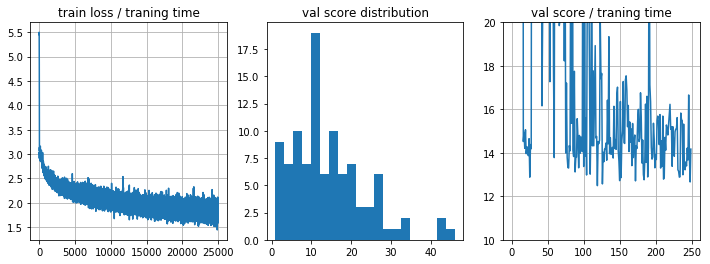

100%|██████████| 25000/25000 [33:32<00:00, 12.42it/s]

llh=1.810, mean score=13.878
שריר הטרפז -> server conter
סוורן סוזוקי -> soren shark
ח'ארג -> harke
מוזיקה מנוונת -> sparting of the conter
אריסימון -> arisania
java -> jama
לטימריה -> lackers
אנווטאק -> antoni
ג'יימי לי קרטיס -> james and state
קטגוריה:ילדי נשיאי ארצות הברית -> arting in the united states


In [33]:
from LSTM_model import LSTMTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = LSTMTranslationModel('model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

s.run(tf.global_variables_initializer())
train(model)

Now let's try GRU instead of LSTM. There are not so many data, so the GRU model can be better, because it has less parameters.

In [34]:
from GRU_model import GRUTranslationModel

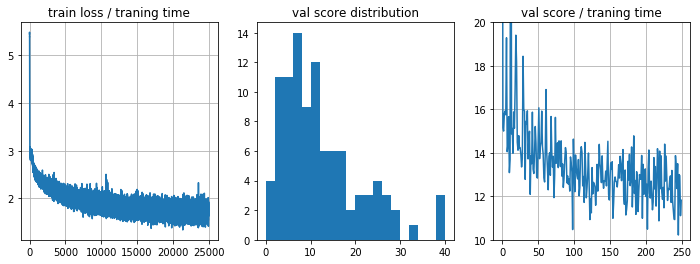

100%|██████████| 25000/25000 [30:16<00:00, 13.77it/s]

llh=1.741, mean score=12.312
שריר הטרפז -> sherric reper
סוורן סוזוקי -> souri sanso
ח'ארג -> zager
מוזיקה מנוונת -> mones of manis
אריסימון -> eriman scholis
java -> jaba
לטימריה -> latimary
אנווטאק -> anotock
ג'יימי לי קרטיס -> jamis tillia
קטגוריה:ילדי נשיאי ארצות הברית -> revers of the united states


In [35]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('model', inp_voc, out_voc,
                            emb_size=32, hid_size=64)

s.run(tf.global_variables_initializer())
train(model)

Acctually, we got the significantly better results with GRU. Now let's try bidirectional encoder.

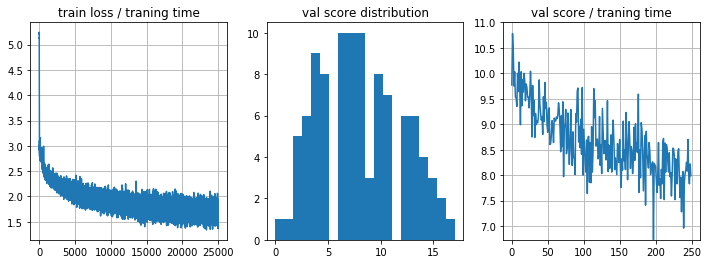

100%|██████████| 25000/25000 [12:44<00:00, 32.69it/s]

llh=1.717, mean score=8.110
כל אנשי סמיילי -> the lish shamili
קטגוריה:ערוץ 2 -> batter of the stort
עבודה מהבית -> adibation arabing
פראליה -> fralia
קפלר 42 -> cator goll
קטגוריה:מתאסלמים -> the mossellers
בושמי -> boshima
לאונרדו -> londro
שאמה -> shama
עכברה -> abrakha


In [23]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('model', inp_voc, out_voc,
                            emb_size=32, hid_size=64, bidirectional=True)

s.run(tf.global_variables_initializer())
train(model)

The results become poorer. However, there is less point using bidirectional encoder without attention. So, now let's try to add attention to our model.

In [20]:
from GRU_with_attention_model import AttentionGRUTranslationModel

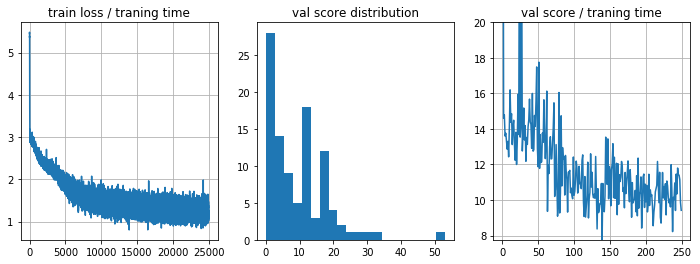

100%|██████████| 25000/25000 [3:31:48<00:00,  1.97it/s]

llh=1.202, mean score=10.723
שריר הטרפז -> serif hatrepes
סוורן סוזוקי -> souran suzucki
ח'ארג -> haharg
מוזיקה מנוונת -> mosica mosic
אריסימון -> arisimon
java -> java
לטימריה -> letimaria
אנווטאק -> anwatack
ג'יימי לי קרטיס -> jami ley kertis
קטגוריה:ילדי נשיאי ארצות הברית -> international artines of ind arthers


In [37]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('model', inp_voc, out_voc,
                                     emb_size=32, hid_size=64, attention_function='bilinear')

s.run(tf.global_variables_initializer())
train(model)

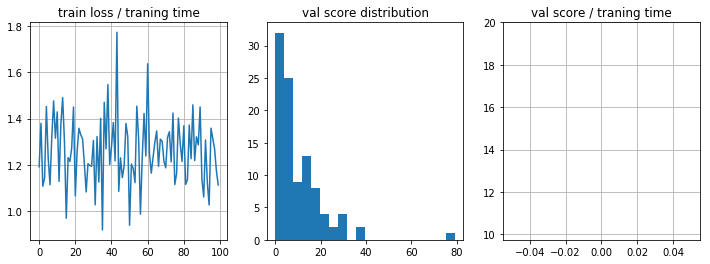

  0%|          | 100/25000 [00:28<1:56:33,  3.56it/s]

llh=1.189, mean score=9.750
שריר הטרפז -> shrier hatrepes
סוורן סוזוקי -> souran susocki
ח'ארג -> haharg
מוזיקה מנוונת -> mosica massoca
אריסימון -> arisimon
java -> java
לטימריה -> latimaria
אנווטאק -> anwatak
ג'יימי לי קרטיס -> jami ley kertis
קטגוריה:ילדי נשיאי ארצות הברית -> national artzian companists


  0%|          | 1/569 [00:00<01:15,  7.50it/s]

keyboard interrupted



  2%|▏         | 13/569 [00:02<01:27,  6.32it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/onaga/.local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 569/569 [01:26<00:00,  6.61it/s]

Supervised test score: 10.1780430119


<function __main__.train.<locals>.translate>

In [40]:
train(model)